# Predictive model for classification

In [1]:
import pandas as pd

DATA = "../data/Customers_clustered.csv"

df_clustered = pd.read_csv(DATA)

df_clustered.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,Age,AgeGroup,MntTotal,MntRegularProds,Children,HasChildren,AcceptedCmpTotal,HasAcceptedCmp,NumTotalPurchases,cluster
0,Graduation,Single,58138.0,0,0,58,635,88,546,172,...,57.0,46-60,1617,1529,0,0,0,0,22,2
1,Graduation,Single,46344.0,1,1,38,11,1,6,2,...,60.0,46-60,27,21,2,1,0,0,4,0
2,Graduation,Partner,71613.0,0,0,26,426,49,127,111,...,49.0,46-60,776,734,0,0,0,0,20,2
3,Graduation,Partner,26646.0,1,0,26,11,4,20,10,...,30.0,18-30,53,48,1,1,0,0,6,0
4,PhD,Partner,58293.0,1,0,94,173,43,118,46,...,33.0,31-45,422,407,1,1,0,0,14,1


In [2]:
X = df_clustered.drop("Response", axis=1)
y = df_clustered["Response"]

In [3]:
X.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,Age,AgeGroup,MntTotal,MntRegularProds,Children,HasChildren,AcceptedCmpTotal,HasAcceptedCmp,NumTotalPurchases,cluster
0,Graduation,Single,58138.0,0,0,58,635,88,546,172,...,57.0,46-60,1617,1529,0,0,0,0,22,2
1,Graduation,Single,46344.0,1,1,38,11,1,6,2,...,60.0,46-60,27,21,2,1,0,0,4,0
2,Graduation,Partner,71613.0,0,0,26,426,49,127,111,...,49.0,46-60,776,734,0,0,0,0,20,2
3,Graduation,Partner,26646.0,1,0,26,11,4,20,10,...,30.0,18-30,53,48,1,1,0,0,6,0
4,PhD,Partner,58293.0,1,0,94,173,43,118,46,...,33.0,31-45,422,407,1,1,0,0,14,1


In [4]:
one_hot_cols = [
    "Education",
    "Marital_Status",
    "AgeGroup",
    "HasChildren", 
    "HasAcceptedCmp", 
    "AcceptedCmp2", 
    "AcceptedCmp3", 
    "AcceptedCmp4", 
    "AcceptedCmp5", 
    "Complain",  
    "Kidhome",
    "Teenhome",
    "YearsSinceEnrolled",
    "Children",
    "AcceptedCmpTotal",
    "cluster"
]

standard_cols = [
    "Income",
    "Age"
]

power_cols = X.columns[
    X.columns.str.startswith("Mnt") | X.columns.str.startswith("Num")
].tolist()

minmax_cols = [
    col for col in X.columns if col not in one_hot_cols + standard_cols + power_cols
]


## **Defining Classification Models**

- We use the **DecisionTreeClassifier** to build a decision tree, which is a model used to classify data based on sequential questions.

- We use **LogisticRegression** to create a relationship between the data, allowing us to predict categories based on logistic regression.

- **KNNClassifier** finds the most similar data points (neighbors) to classify new examples based on similarities between features.

- **DummyClassifier** serves as a basic classifier that makes simple predictions, such as always choosing the most frequent class. It is used as a reference to determine if the other models are truly learning something useful.



## **Created Function**

### **Three-Step Function:**

1. **Preprocessing**  
   This step handles data preprocessing tasks, including:
   - Standardization of data;
   - Encoding of categorical variables;
   - Normalization or scaling of data.

2. **Pipeline**  
   In this step, a pipeline is created to automate the data preparation and modeling process. It includes:
   - Reuse of the preprocessing defined earlier;
   - Selection of the **10 best features** based on a chosen criterion (like `SelectKBest`);
   - Dimensionality reduction (such as PCA or other techniques);
   - Application of the **chosen model** to train and make predictions.

3. **Scores**  
   Finally, this step evaluates the model's performance. It returns **evaluation metrics**, such as:
   - accuracy;
   - precision;
   - recall;
   - roc_auc;
   - average_precision, among others.  
   This allows us to compare different models and determine which one performed the best.


In [5]:
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    MinMaxScaler,
    PowerTransformer,
)
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from imblearn.pipeline import Pipeline  # atenção para o Pipeline do ImbLearn
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_validate

RANDOM_STATE = 42

models = {
    "DummyClassifier": DummyClassifier(
        strategy="stratified", random_state=RANDOM_STATE
    ),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "LogisticRegression": LogisticRegression(random_state=RANDOM_STATE),
    "KNNClassifier": KNeighborsClassifier(n_neighbors=5),
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)


def pipeline_model(X, y, model, kf):
    preprocessing = ColumnTransformer(
        [
            ("one-hot", OneHotEncoder(), one_hot_cols),
            ("standard", StandardScaler(), standard_cols),
            ("minmax", MinMaxScaler(), minmax_cols),
            ("power", PowerTransformer(), power_cols),
        ]
    )

    pipeline = Pipeline(
        [
            ("preprocessing", preprocessing),
            ("feature_selection", SelectKBest(score_func=f_classif, k=10)),
            ("rus", RandomUnderSampler(random_state=RANDOM_STATE)),
            ("model", model),
        ]
    )

    scores = cross_validate(
        pipeline,
        X,
        y,
        cv=kf,
        scoring=["accuracy", "precision", "recall", "roc_auc", "average_precision"],
        n_jobs=-1,
    )

    return scores

In [6]:
results = {
    "DummyClassifier": pipeline_model(X, y, models["DummyClassifier"], skf),
    "DecisionTreeClassifier": pipeline_model(X, y, models["DecisionTreeClassifier"], skf),
    "LogisticRegression": pipeline_model(X, y, models["LogisticRegression"], skf),
    "KNNClassifier": pipeline_model(X, y, models["KNNClassifier"], skf),
}


## **Observing the Results**

- The code below demonstrates a dictionary containing the four selected models and their best evaluations based on the five metrics we used.


In [7]:
from pprint import pprint

pprint(results)

{'DecisionTreeClassifier': {'fit_time': array([0.1205852 , 0.1205833 , 0.11735487, 0.11943841, 0.11543059]),
                            'score_time': array([0.0446856 , 0.04858422, 0.04683757, 0.0467608 , 0.04111433]),
                            'test_accuracy': array([0.78911565, 0.68707483, 0.75736961, 0.79818594, 0.67346939]),
                            'test_average_precision': array([0.34862827, 0.25056152, 0.37626684, 0.37587657, 0.19788298]),
                            'test_precision': array([0.34883721, 0.27096774, 0.31818182, 0.38613861, 0.23648649]),
                            'test_recall': array([0.44776119, 0.62686567, 0.52238806, 0.59090909, 0.53030303]),
                            'test_roc_auc': array([0.69359087, 0.66322133, 0.69283263, 0.77745455, 0.61442424])},
 'DummyClassifier': {'fit_time': array([0.22536278, 0.17076612, 0.15030408, 0.12001514, 0.11396241]),
                     'score_time': array([0.07585597, 0.05815148, 0.05084538, 0.04457068, 0.04449701

In [8]:
for k, v in results.items():
    results[k]["time"] = results[k]["fit_time"] + results[k]["score_time"]

pprint(results)

{'DecisionTreeClassifier': {'fit_time': array([0.1205852 , 0.1205833 , 0.11735487, 0.11943841, 0.11543059]),
                            'score_time': array([0.0446856 , 0.04858422, 0.04683757, 0.0467608 , 0.04111433]),
                            'test_accuracy': array([0.78911565, 0.68707483, 0.75736961, 0.79818594, 0.67346939]),
                            'test_average_precision': array([0.34862827, 0.25056152, 0.37626684, 0.37587657, 0.19788298]),
                            'test_precision': array([0.34883721, 0.27096774, 0.31818182, 0.38613861, 0.23648649]),
                            'test_recall': array([0.44776119, 0.62686567, 0.52238806, 0.59090909, 0.53030303]),
                            'test_roc_auc': array([0.69359087, 0.66322133, 0.69283263, 0.77745455, 0.61442424]),
                            'time': array([0.16527081, 0.16916752, 0.16419244, 0.16619921, 0.15654492])},
 'DummyClassifier': {'fit_time': array([0.22536278, 0.17076612, 0.15030408, 0.12001514, 0.1139624


## 📊 **Creating a Results DataFrame**

We created a new DataFrame to **store and organize the results** obtained from the evaluation metrics. This helps in comparing model performance more easily and visually.



In [9]:
df_results = pd.DataFrame(results).T.reset_index().rename(columns = ({"index": "model"}))
df_results

,model,fit_time,score_time,test_accuracy,test_precision,test_recall,test_roc_auc,test_average_precision,time
0,DummyClassifier,"[0.22536277770996094, 0.17076611518859863, 0.1...","[0.07585597038269043, 0.0581514835357666, 0.05...","[0.5124716553287982, 0.5034013605442177, 0.503...","[0.1542056074766355, 0.14485981308411214, 0.14...","[0.4925373134328358, 0.4626865671641791, 0.462...","[0.5042900470907494, 0.4866908771649773, 0.486...","[0.15304952129175473, 0.14865734269715697, 0.1...","[0.30121874809265137, 0.22891759872436523, 0.2..."
1,DecisionTreeClassifier,"[0.12058520317077637, 0.12058329582214355, 0.1...","[0.04468560218811035, 0.0485842227935791, 0.04...","[0.7891156462585034, 0.6870748299319728, 0.757...","[0.3488372093023256, 0.2709677419354839, 0.318...","[0.44776119402985076, 0.6268656716417911, 0.52...","[0.6935908691834943, 0.6632213265224679, 0.692...","[0.34862827024779675, 0.2505615170885016, 0.37...","[0.16527080535888672, 0.16916751861572266, 0.1..."
2,LogisticRegression,"[0.14799141883850098, 0.14497613906860352, 0.1...","[0.05120134353637695, 0.04818367958068848, 0.0...","[0.8027210884353742, 0.7437641723356009, 0.793...","[0.38372093023255816, 0.32575757575757575, 0.3...","[0.4925373134328358, 0.6417910447761194, 0.597...","[0.738885784978849, 0.7400830074227791, 0.7636...","[0.4453298240052239, 0.45495242165461897, 0.40...","[0.19919276237487793, 0.193159818649292, 0.168..."
3,KNNClassifier,"[0.11390995979309082, 0.11189579963684082, 0.1...","[0.08617401123046875, 0.08416485786437988, 0.0...","[0.81859410430839, 0.6961451247165533, 0.81405...","[0.40298507462686567, 0.2689655172413793, 0.41...","[0.40298507462686567, 0.582089552238806, 0.552...","[0.6887022108707798, 0.6896599888259238, 0.727...","[0.36196918641993425, 0.27251725056618004, 0.3...","[0.20008397102355957, 0.1960606575012207, 0.21..."


In [10]:
df_results_explode = df_results.explode(
    df_results.columns[1:].to_list()
).reset_index(drop=True)

df_results_explode

,model,fit_time,score_time,test_accuracy,test_precision,test_recall,test_roc_auc,test_average_precision,time
0,DummyClassifier,0.225363,0.075856,0.512472,0.154206,0.492537,0.50429,0.15305,0.301219
1,DummyClassifier,0.170766,0.058151,0.503401,0.14486,0.462687,0.486691,0.148657,0.228918
2,DummyClassifier,0.150304,0.050845,0.503401,0.14486,0.462687,0.486691,0.148657,0.201149
3,DummyClassifier,0.120015,0.044571,0.487528,0.126168,0.409091,0.455212,0.14005,0.164586
4,DummyClassifier,0.113962,0.044497,0.510204,0.149533,0.484848,0.499758,0.149598,0.158459
5,DecisionTreeClassifier,0.120585,0.044686,0.789116,0.348837,0.447761,0.693591,0.348628,0.165271
6,DecisionTreeClassifier,0.120583,0.048584,0.687075,0.270968,0.626866,0.663221,0.250562,0.169168
7,DecisionTreeClassifier,0.117355,0.046838,0.75737,0.318182,0.522388,0.692833,0.376267,0.164192
8,DecisionTreeClassifier,0.119438,0.046761,0.798186,0.386139,0.590909,0.777455,0.375877,0.166199
9,DecisionTreeClassifier,0.115431,0.041114,0.673469,0.236486,0.530303,0.614424,0.197883,0.156545



## 📈 **Creating Performance Charts**

To better visualize and compare model results, we created performance charts using key evaluation metrics.

By adopting **`average_precision`** as our main reference metric — since it performs better on **imbalanced datasets** — we can clearly see that the **Logistic Regression** model stands out compared to the others.



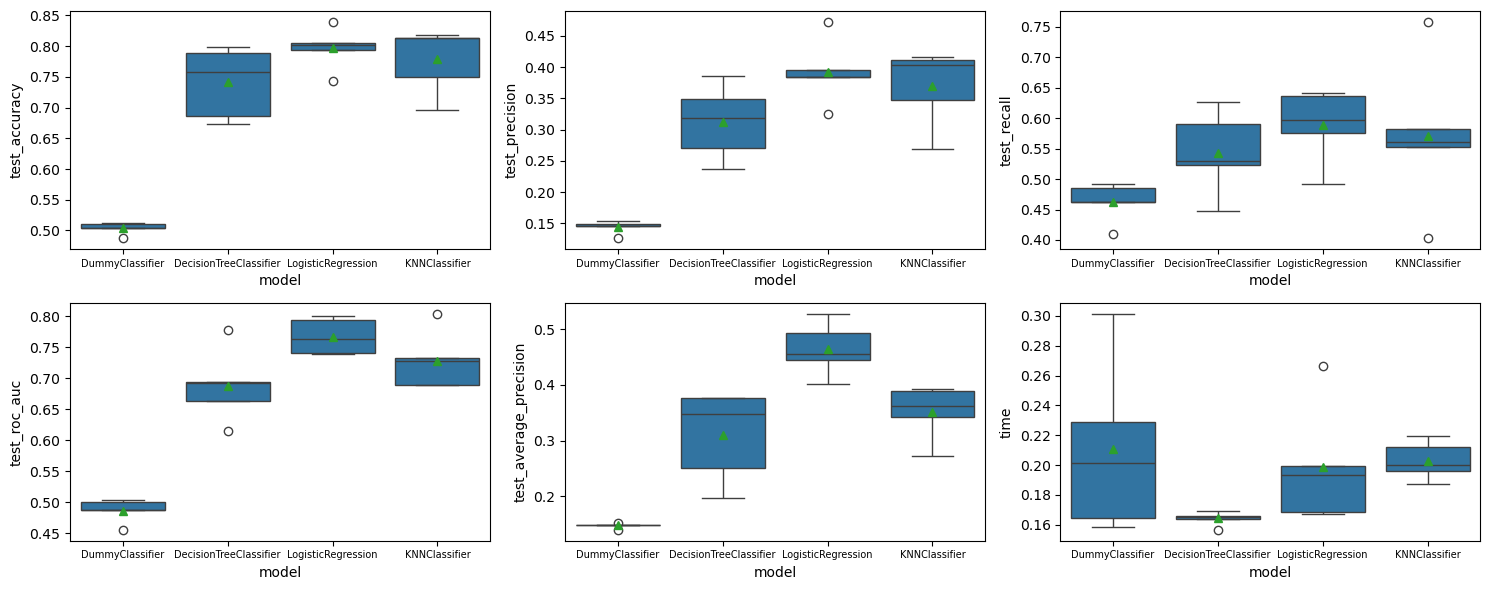

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 6), tight_layout=True)

cols = df_results.columns[3:].to_list()

for ax, col in zip(axs.flatten() , cols):
    b= sns.boxplot(x="model", y=col, data=df_results_explode, ax=ax, showmeans=True)
    tick_positions = b.get_xticks()
    tick_labels = [tick.get_text() for tick in b.get_xticklabels()]
    b.set_xticks(tick_positions)
    b.set_xticklabels(tick_labels, fontsize=7)

plt.savefig('grafico3.png')